In [4]:
##### Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

#from numpy import argmax, array_equal
import tensorflow
#Import Keras packages for neural network design
from keras.models import Sequential
#from keras import layers, lossespip list

from tensorflow.keras import layers,losses
from keras.layers import Dense, Input, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, MaxPool2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import Model, load_model
from keras import regularizers
from sklearn.utils import shuffle

import imgaug.augmenters as augmenters
# from imgaug import augmenters
from random import randint

#Set a random seed for reproducibility.
np.random.seed(42)

ModuleNotFoundError: No module named 'imgaug'

In [2]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_me(x_data, y_data, title, x_name, y_name):
    plt.barh(y_data, x_data)
    plt.title(title)
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

def get_count(dict_labels, labels):
    counts_labels = []
    counts = []
    for x in range(len(dict_labels)):
        counts_labels.append(dict_labels[x])
        cat_count = np.count_nonzero(labels == x)
        counts.append(cat_count)
        
    return (counts, counts_labels)
    
def shuffle_and_inspect(dict_labels, x_data, y_data, data_set):
    print("Shuffling")
    xs_data, ys_data = shuffle(x_data, y_data)
    
    #print("####### Inspecting after shuffling #######")
    counts, counts_labels = get_count(labeldict, ys_data)
    plot_me(counts, counts_labels, data_set, "Number of elements in category", "Category")
    
    return (xs_data, ys_data)

def variance(X): 
    mean = sum (X) / len (X)
    tot = 0.0
    #deviations = [(x - mean) ** 2 for x in X]
    #variance = sum(deviations) / len(X)
    #print("variance inner: ", variance)
    for x in X:
        tot = tot + (x - mean) ** 2
    return tot / len (X)
    # call the function with data set.
    
def detailed_inspect(x_data, y_data):
    print("#################")
    counts, counts_labels = get_count(labeldict, y_data)
    print("Variance: ", variance(counts))
    print("max: ", max(counts))
    print("min: ", min(counts))
    print("max-min: ", max(counts) - min(counts))
    print("#################")


In [57]:
FIND_VARIANCE_LOOP = 10
ACCEPTABLE_VARIANCE = 0
"""
Method takes in the training set, and splits it to training and validation set.
Sometimes the split method from sklearn is splitting the data with quite high variance, so we sometimes 
had the training set with a lot less t-shirts and validation set with a lot of t-shirts for example.

In order to try and minimize the variance, we set an acceptable amount of variance, and a maximum loop count.
We then split the data, until an acceptable variance is reached or until we've reached our max loop count.

If the max loop count is reached, we'll throw an error here with some details about what results we got from the splits.
"""
def get_acceptable_split(x_train, y_train):
    print("Splitting data up to ", FIND_VARIANCE_LOOP, " times, or until acceptable variance (", ACCEPTABLE_VARIANCE,") is found.")
    i = 0
    vars_found = []
    acceptable_var_found = False
    while i < FIND_VARIANCE_LOOP:
        i+=1
        ## Split train set into train and validation (16,666% validation = 10000 images)
        s_x_train, x_val, s_y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.16666)
        
        # ... Every day I'm shuffling
        s_x_train, s_y_train = shuffle(s_x_train, s_y_train)
        
        # Get count of each category of clothing in the validation set:
        counts, counts_labels = get_count(labeldict, y_val)
        
        # Get variance ("spread") of the catagorized data
        # variance will be the same for val and train, and val is smaller so we'll use that
        val_variance = variance(counts)
        
        vars_found.append(val_variance) # Add variance found to a list in case startification didn't work
        
        # Set boolean variable to True if our acceptable variance limit was met
        # Originally made before we were using stratification when splitting the dataset, but decided to keep it
        # in case stratification were to fail - throwing an error if we don't get 0 variance.
        acceptable_var_found = val_variance <= ACCEPTABLE_VARIANCE
        if(acceptable_var_found):
            print("Acceptable variance found: ", val_variance)
            print("We looped ", i, " times to find it!")
            x_train = s_x_train
            y_train = s_y_train
            i=FIND_VARIANCE_LOOP
            acceptable_var = True
    
    if(acceptable_var_found == False):
        min_found = min(vars_found)
        msg = "Couldn't find acceptable variance."
        stats = "Loop count: ", FIND_VARIANCE_LOOP, ", best variance found: ", min_found, ", but acceptable is set to: ", ACCEPTABLE_VARIANCE 
        instructions = "Try setting the loop count to be higher (FIND_VARIANCE_LOOP), or lower the ACCEPTABLE_VARIANCE, or just try running it again"
        raise Exception(msg, stats, instructions)
    
    return ((x_train, y_train), (x_val, y_val))

In [58]:
def get_and_split_data():
    #Load in the Fashion MNIST data set.
    
    print("Fetching data")
    from keras.datasets import fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    

    # Get split data with acceptable variance
    (x_train, y_train), (x_val, y_val) = get_acceptable_split(x_train, y_train)
    
    print("Training set after splitting:")
    x_train, y_train = shuffle_and_inspect(labeldict, x_train, y_train, "Training data after split")
    
    print("Lets get a few more details of the training set: ")
    detailed_inspect(x_train, y_train)
    
    print("Validation set:")
    x_val, y_val = shuffle_and_inspect(labeldict, x_val, y_val, "Validation data")
    
    print("Lets get a few more details of the validation set: ")
    detailed_inspect(x_val, y_val)

    #x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    #x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    
    print("In get and split data we have these shapes:")
    print("x train: ", x_train.shape)
    print("y train: ", y_train.shape)
    print("x val:   ", x_val.shape)
    print("y val:   ",  y_val.shape)
    print("x test:  ", x_test.shape)
    print("y test:  ", y_test.shape)
    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))
    

Fetching data
Splitting data up to  10  times, or until acceptable variance ( 0 ) is found.
Acceptable variance found:  0.0
We looped  1  times to find it!
Training set after splitting:
Shuffling


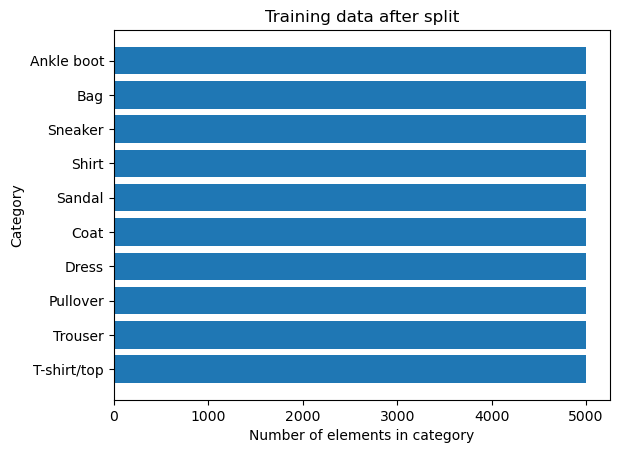

Lets get a few more details of the training set: 
#################
Variance:  0.0
max:  5000
min:  5000
max-min:  0
#################
Validation set:
Shuffling


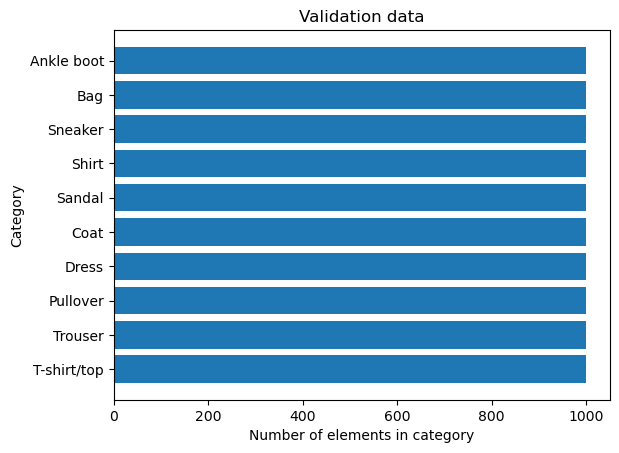

Lets get a few more details of the validation set: 
#################
Variance:  0.0
max:  1000
min:  1000
max-min:  0
#################
In get and split data we have these shapes:
x train:  (50000, 28, 28)
y train:  (50000,)
x val:    (10000, 28, 28)
y val:    (10000,)
x test:   (10000, 28, 28)
y test:   (10000,)


In [59]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_and_split_data()

In [6]:
def shape_cnn_data():   
    #Reshape the data to have depth of 1.
    cnn_x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    cnn_x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
    cnn_x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

    #Grayscale values run from 0 to 256.  This scales that data to a 0 to 1 range and converts to float.
    #Perhaps unnecessary with Fashion MNIST, but scaling like this is best practice with image data.
    #It also may improve computation efficiency.
    cnn_x_train = cnn_x_train/255.
    cnn_x_val = cnn_x_val/255.
    cnn_x_test = cnn_x_test/255.

    #The target variable needs to be one-hot encoded, i.e.; converted into a purely categorical form.
    #Leaving it as 0-9 would create false proximity relationships between the categories.
    cnn_y_train = np_utils.to_categorical(y_train, 10)
    cnn_y_val = np_utils.to_categorical(y_val, 10)
    cnn_y_test = np_utils.to_categorical(y_test, 10)

    print("Lets see some shapes again after working with the data:")
    print("x train: ", cnn_x_train.shape)
    print("y train: ", cnn_y_train.shape)
    print("x val:   ", cnn_x_val.shape)
    print("y val:   ",  cnn_y_val.shape)
    print("x test:  ", cnn_x_test.shape)
    print("y test:  ", cnn_y_test.shape)
    return ((cnn_x_train, cnn_y_train), (cnn_x_val, cnn_y_val), (cnn_x_test, cnn_y_test))

def create_cnn():
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    cnn.add(Dropout(0.3))
    cnn.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.2))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.05))
    cnn.add(Dense(10, activation='softmax'))
    return cnn

def scheduler (epochs):
    if epochs <= 5:
        return 0.001
    elif epochs <= 15:
        return 0.0005
    else :
        return 0.00001


In [7]:
BATCH_SIZE = 128
EPOCHS = 30

def train_and_save_cnn():
    print("Shaping data for the cnn")
    (cnn_x_train, cnn_y_train), (cnn_x_val, cnn_y_val), (cnn_x_test, cnn_y_test) = shape_cnn_data()

    print("Creating cnn")
    cnn = create_cnn()
    
    print("Compiling cnn")
    cnn.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
    
    print("Setting learning rate")
    learning_rate = LearningRateScheduler(scheduler , verbose=0)
    
    print("Setting model checkpoint to save best model based on validation accuracy")
    #ModelCheckpoint allows us to extract the best end-of-epoch model.
    #Under different circumstances, we might monitor validation loss instead of validation accuracy.
    checkpoint = ModelCheckpoint(filepath='cnn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    print("Setting callback_list")
    callback_list=[learning_rate, checkpoint]
    
    print("CNN Summary:")
    cnn.summary()
    
    print(" ####################### ")
    print("Fitting the model:")
    print("BATCH_SIZE: ", BATCH_SIZE)
    print("EPOCHS: ", EPOCHS)
    cnn.fit(
        cnn_x_train,
        cnn_y_train,
        #validation_split=0.17,
        validation_data=(cnn_x_val, cnn_y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        shuffle=True,
        verbose=1,
        callbacks=callback_list
    )
    return (cnn, (cnn_x_test, cnn_y_test))

In [8]:
def accuracy_loss_plots(model):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
    ax1.plot(model.history.history['val_accuracy'])
    ax1.set_title('Test Accuracy by Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(0.8,1)
    ax2.plot(model.history.history['loss'], label='Training loss')
    ax2.plot(model.history.history['val_loss'], label='Validation loss')
    ax2.set_title('Loss Reduction by Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(0,1)
    ax2.legend();
    
def get_confusion_matrix(cnn_x_test, cnn_y_test):
    from sklearn.metrics import confusion_matrix
    from itertools import product

    classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

    #Create Multiclass Confusion Matrix
    preds = cnn_best.predict(cnn_x_test)
    cm = confusion_matrix(np.argmax(cnn_y_test,axis=1), np.argmax(preds,axis=1))

    plt.figure(figsize=(8,8))
    plt.imshow(cm,cmap=plt.cm.Reds)
    plt.title('Fashion MNIST Confusion Matrix - CNN')
    plt.colorbar()
    plt.xticks(np.arange(10), classes, rotation=90)
    plt.yticks(np.arange(10), classes)

    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [9]:
def accuracy_loss_plots(model):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
    ax1.plot(model.history.history['val_accuracy'])
    ax1.set_title('Test Accuracy by Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(0.8,1)
    ax2.plot(model.history.history['loss'], label='Training loss')
    ax2.plot(model.history.history['val_loss'], label='Validation loss')
    ax2.set_title('Loss Reduction by Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(0,1)
    ax2.legend();
    
def get_confusion_matrix(cnn_x_test, cnn_y_test):
    from sklearn.metrics import confusion_matrix
    from itertools import product

    classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

    #Create Multiclass Confusion Matrix

    preds = cnn_best.predict(cnn_x_test)
    cm = confusion_matrix(np.argmax(cnn_y_test,axis=1), np.argmax(preds,axis=1))

    plt.figure(figsize=(8,8))
    plt.imshow(cm,cmap=plt.cm.Reds)
    plt.title('Fashion MNIST Confusion Matrix - CNN')
    plt.colorbar()
    plt.xticks(np.arange(10), classes, rotation=90)
    plt.yticks(np.arange(10), classes)

    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [10]:
print("Calling train_and_save_cnn()")
(cnn), (cnn_x_test, cnn_y_test) = train_and_save_cnn()

Calling train_and_save_cnn()
Shaping data for the cnn
Lets see some shapes again after working with the data:
x train:  (50000, 28, 28, 1)
y train:  (50000, 10)
x val:    (10000, 28, 28, 1)
y val:    (10000, 10)
x test:   (10000, 28, 28, 1)
y test:   (10000, 10)
Creating cnn
Metal device set to: Apple M1 Pro


2022-12-19 13:57:21.165415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 13:57:21.165837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Compiling cnn
Setting learning rate
Setting model checkpoint to save best model based on validation accuracy
Setting callback_list
CNN Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                            

2022-12-19 13:57:21.736939: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 13:57:22.024354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7560

2022-12-19 13:57:32.281397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 11s 28ms/step - loss: 0.6690 - accuracy: 0.7560 - val_loss: 0.9656 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 2/3
391/391 [==============================] - 10s 26ms/step - loss: 0.3789 - accuracy: 0.8618 - val_loss: 0.3413 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 3/3
391/391 [==============================] - 10s 26ms/step - loss: 0.3161 - accuracy: 0.8867 - val_loss: 0.2726 - val_accuracy: 0.9049 - lr: 0.0010


 ######################################################### 
Finished training, printing accuracy:


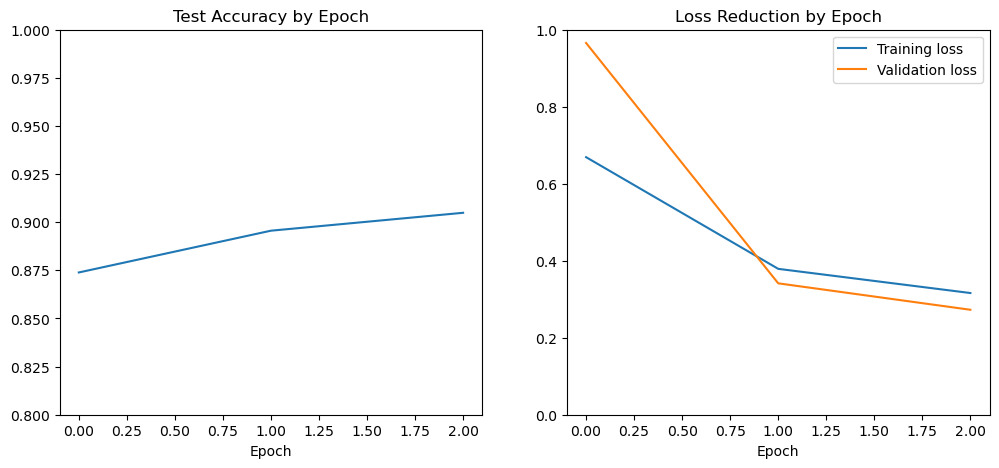

In [11]:
print(" ######################################################### ")
print("Finished training, printing accuracy:")
accuracy_loss_plots(cnn)

In [12]:
print(" ######################################################### ")
print("Evaluating our model:")
cnn.evaluate(cnn_x_test,cnn_y_test)

 ######################################################### 
Evaluating our model:
313/313 [==============================] - 3s 9ms/step - loss: 0.2898 - accuracy: 0.8960


[0.28976523876190186, 0.8960000276565552]

In [13]:
print(" ######################################################### ")
#Load in the best model state from ModelCheckpoint
print("Loading our best (saved) model.")
cnn_best = load_model('cnn.h5')

 ######################################################### 
Loading our best (saved) model.


In [14]:
print(" ######################################################### ")
#Confirm loss and accuracy on the test data
print("Evaluating our best model:")
cnn_best.evaluate(cnn_x_test,cnn_y_test)

 ######################################################### 
Evaluating our best model:
 11/313 [>.............................] - ETA: 3s - loss: 0.2412 - accuracy: 0.9233

2022-12-19 13:58:07.740656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step - loss: 0.2898 - accuracy: 0.8960


[0.28976523876190186, 0.8960000276565552]

 ######################################################### 
Confusion matrix
 25/313 [=>............................] - ETA: 1s

2022-12-19 13:58:11.434045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step


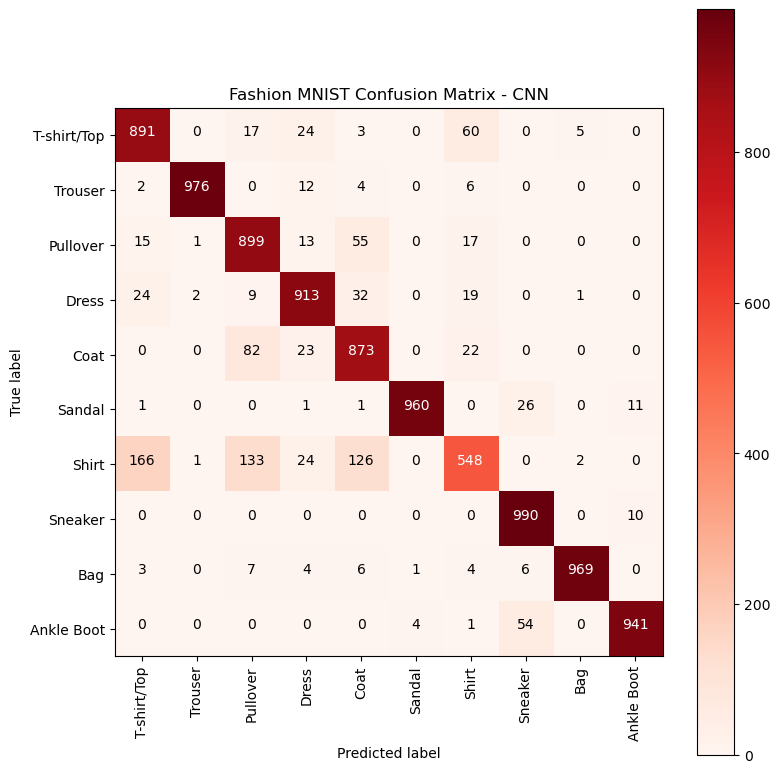

In [15]:
print(" ######################################################### ")
print("Confusion matrix")
get_confusion_matrix(cnn_x_test, cnn_y_test)

In [16]:
def shape_autoencoder_data():
    ae_x_train = x_train/255
    ae_x_val = x_val/255
    
    ae_x_train = ae_x_train.reshape(-1, 28, 28, 1)
    ae_x_val = ae_x_val.reshape(-1, 28, 28, 1)
    return (ae_x_train, ae_x_val)

def get_sap_noisy_training_set(ae_x_train, ae_x_val):
    noise = augmenters.SaltAndPepper(0.1)
    seq_object = augmenters.Sequential([noise])

    ae_x_train_n = seq_object.augment_images(ae_x_train * 255) / 255
    ae_x_val_n = seq_object.augment_images(ae_x_val * 255) / 255
    return (ae_x_train_n, ae_x_val_n)

def get_sap_noisy_cnn_data(x_data, y_data):
    
    noise = augmenters.SaltAndPepper(0.1)
    seq_object = augmenters.Sequential([noise])
    
    x_data = x_data.reshape(-1, 28, 28, 1)
    x_data = x_data/255.
    y_data = np_utils.to_categorical(y_data, 10)
    
    x_data = seq_object.augment_images(x_data * 255) / 255
    return (x_data, y_data)

def plot_images(data_set, i_start, i_end):
    total = i_end - i_start
    f, ax = plt.subplots(1,total)
    f.set_size_inches(80, 40)
    for i in range(i_start,i_end):
        ax[i-i_start].imshow(data_set[i].reshape(28, 28))
    plt.show()

Plotting training images with indexes, I_START:  7  I_END:  12


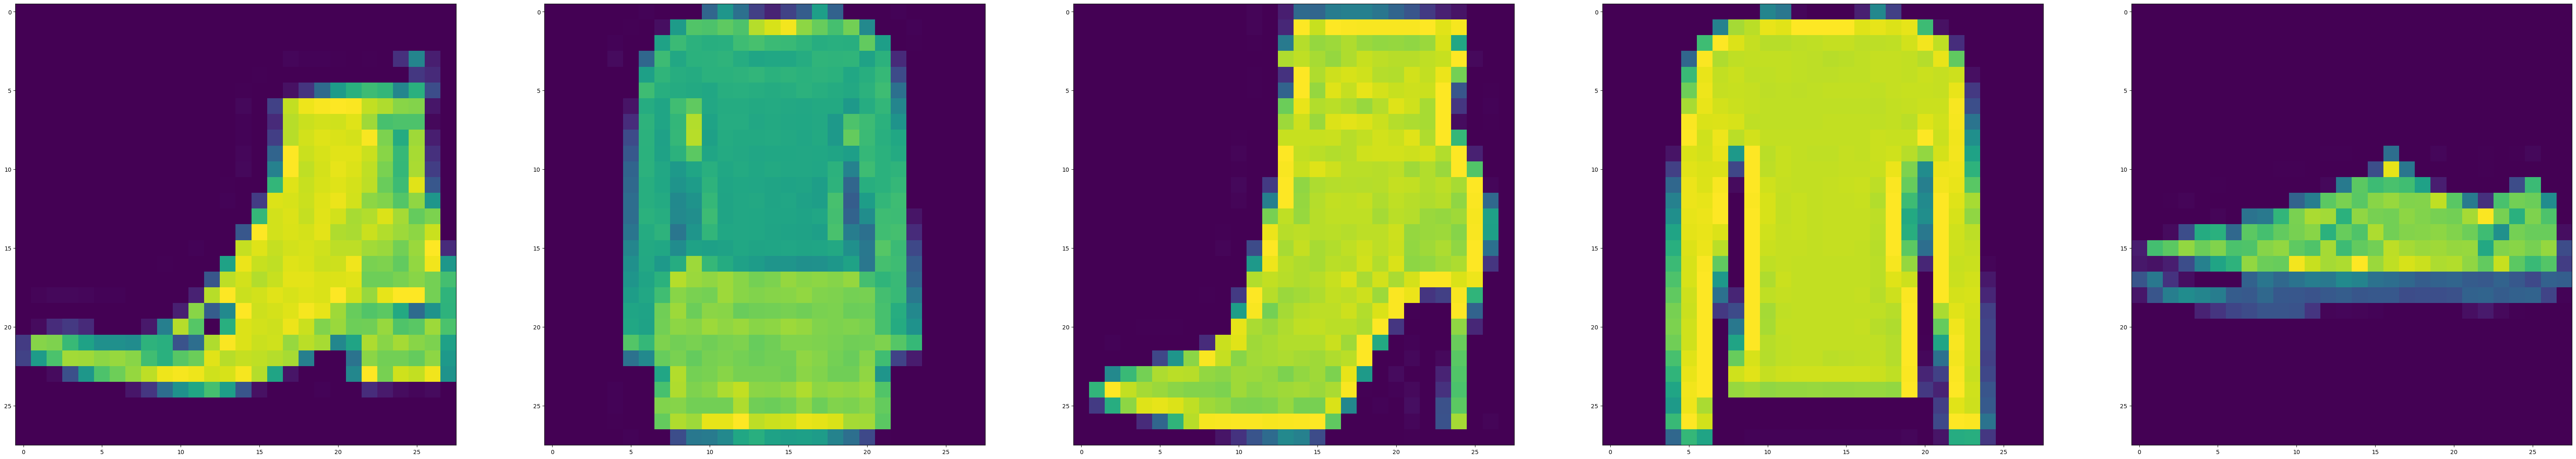

Plotting noisy training images with indexes, I_START:  7  I_END:  12


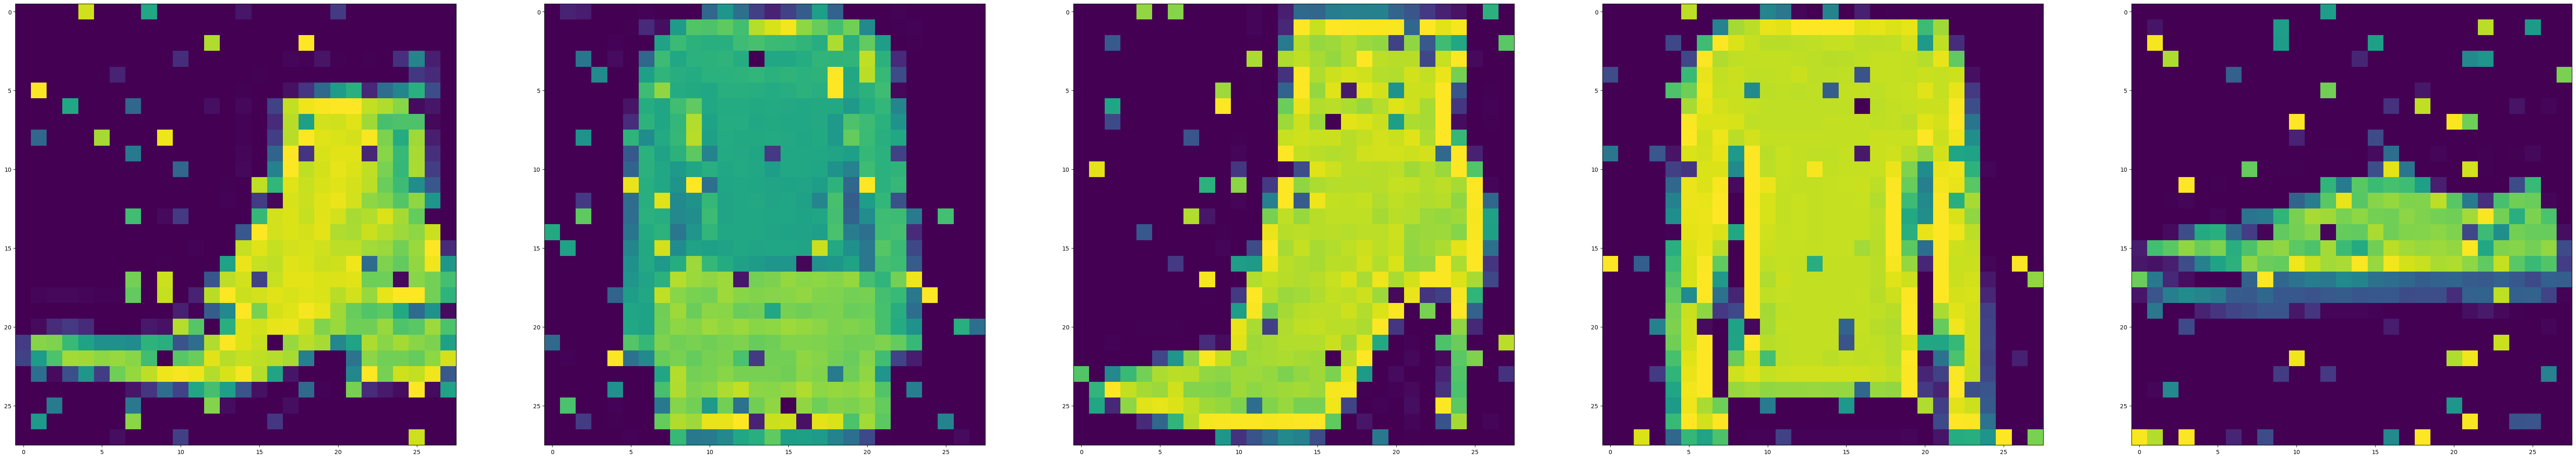

In [17]:
ae_x_train, ae_x_val = shape_autoencoder_data()
ae_x_train_n, ae_x_val_n = get_sap_noisy_training_set(ae_x_train, ae_x_val)

I_START = 7
I_END = 12

print("Plotting training images with indexes, I_START: ", I_START, " I_END: ", I_END)
plot_images(ae_x_train, I_START, I_END)

print("Plotting noisy training images with indexes, I_START: ", I_START, " I_END: ", I_END)
plot_images(ae_x_train_n, I_START, I_END)

In [19]:
"""
Testing cnn with regular testing images and noisy images to see how much difference
"""
x_test_n, y_test_n = get_sap_noisy_cnn_data(x_test, y_test)
cnn_best.evaluate(x_test_n,y_test_n)
cnn_best.evaluate(cnn_x_test, cnn_y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.2898 - accuracy: 0.8960


[0.28976523876190186, 0.8960000276565552]

In [20]:
def get_autoencoder():
    # input layer 
    input_layer = Input(shape=(28, 28, 1))

    # Encoding Architecture
    encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    encoded_layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
    encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

    #encoded_layer1 = BatchNormalization()(encoded_layer1)
    
    encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
    encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer2)
    encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
    
    #encoded_layer2 = BatchNormalization()(encoded_layer2)

    encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
    encoded_layer3 = Conv2D(4, (2, 2), activation='relu', padding='same')(encoded_layer3)

    latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

    # decoding architecture
    #decoded_layer1 = Reshape((2, 2, 1))(latent_view)
    decoded_layer1 = Conv2D(4, (2, 2), activation='relu', padding='same')(latent_view)
    decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer1)
    #decoded_layer1 = BatchNormalization()(decoded_layer1)
    decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

    decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
    decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer2)
    #decoded_layer2 = BatchNormalization()(decoded_layer2)
    decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)

    decoded_layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer2)
    decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer3)
    decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)


    output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
    return (input_layer, output_layer)
    #dimension of output layer == input layer because we need denoised image thats why there is no dense layer on

In [21]:
input_layer, output_layer = get_autoencoder()
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [22]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                             

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,
                               patience=10, verbose=5, mode='auto')
"""
ae_x_train, 
ae_x_val 

ae_x_train_n, 
ae_x_val_n
"""
history = model_2.fit(
    #train_x_n, 
    #train_x, 
    ae_x_train,
    ae_x_train_n,
    epochs=25, 
    batch_size=2048, 
    validation_data=(ae_x_val, ae_x_val_n), 
    callbacks=[early_stopping]
)

Epoch 1/25


2022-12-19 13:59:29.657458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.1139

2022-12-19 13:59:42.301421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 14s 515ms/step - loss: 0.1139 - val_loss: 0.0869
Epoch 2/25
25/25 [==============================] - 12s 493ms/step - loss: 0.0731 - val_loss: 0.0626
Epoch 3/25
25/25 [==============================] - 13s 504ms/step - loss: 0.0583 - val_loss: 0.0550
Epoch 4/25
25/25 [==============================] - 13s 494ms/step - loss: 0.0528 - val_loss: 0.0512
Epoch 5/25
25/25 [==============================] - 13s 495ms/step - loss: 0.0500 - val_loss: 0.0490
Epoch 6/25
25/25 [==============================] - 13s 508ms/step - loss: 0.0487 - val_loss: 0.0479
Epoch 7/25
25/25 [==============================] - 12s 490ms/step - loss: 0.0473 - val_loss: 0.0468
Epoch 8/25
25/25 [==============================] - 13s 501ms/step - loss: 0.0466 - val_loss: 0.0460
Epoch 9/25
25/25 [==============================] - 13s 536ms/step - loss: 0.0459 - val_loss: 0.0461
Epoch 10/25
25/25 [==============================] - 13s 523ms/step - loss: 0.0453 - val_loss: 0.0450


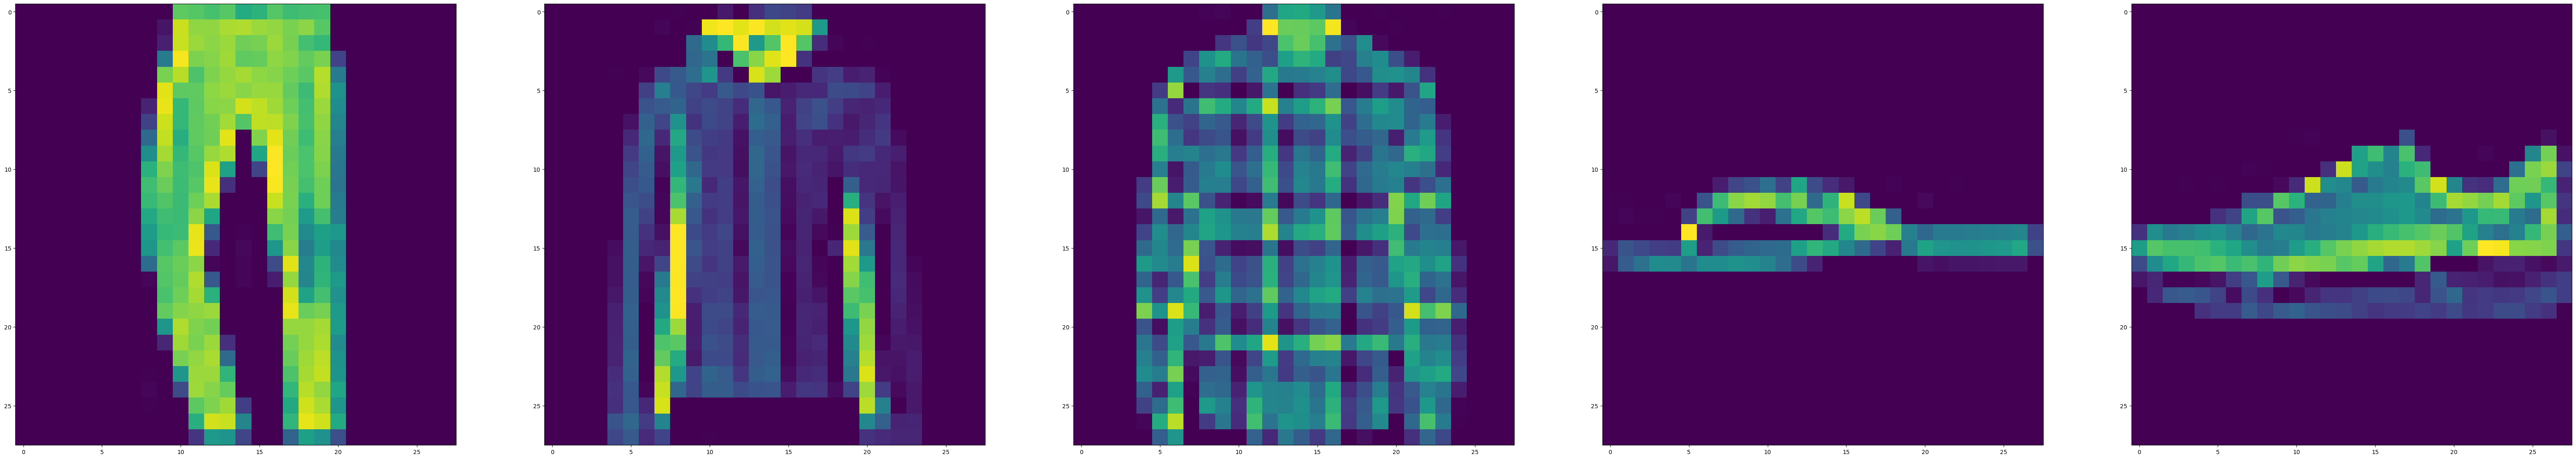


  1/313 [..............................] - ETA: 1:08

2022-12-19 14:08:04.840997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step


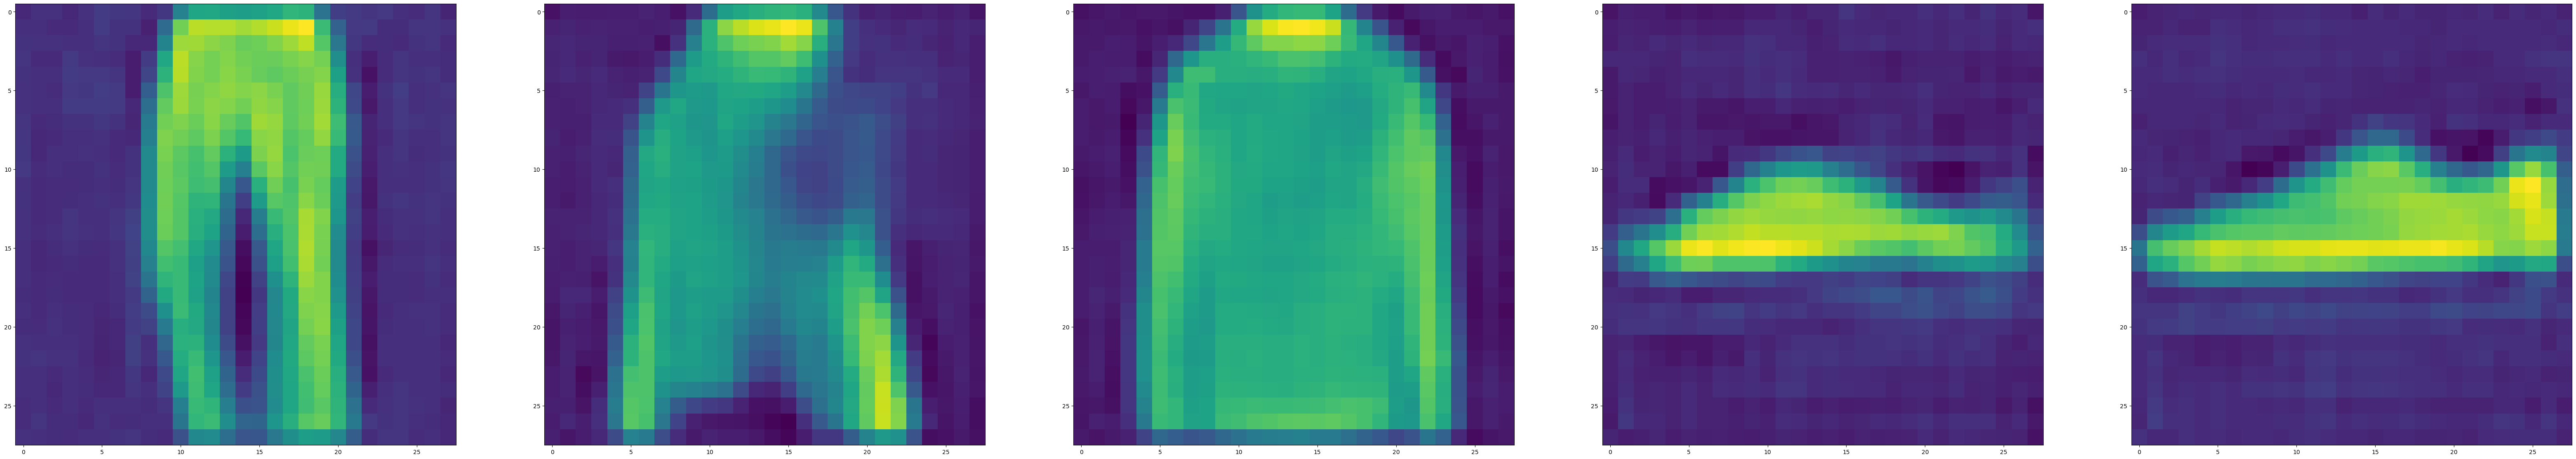

313/313 [==============================] - 3s 8ms/step


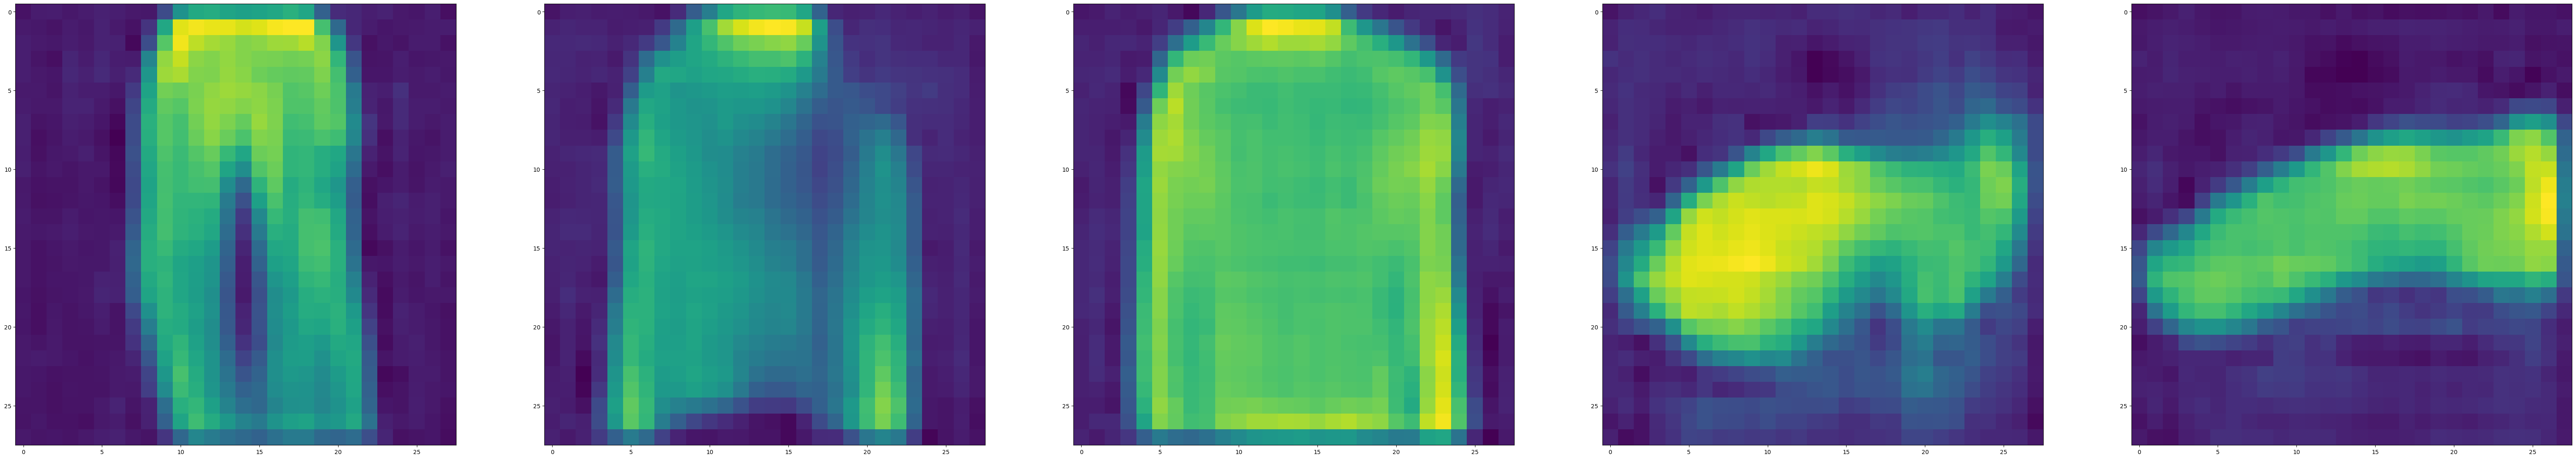

In [24]:
#print("##########################################")
plot_images(cnn_x_test, 5, 10)
#plot_images(cnn_x_test, 10, 15)
#plot_images(cnn_x_test, 15, 20)
#plot_images(cnn_x_test, 300, 305)
#print("##########################################")
# Regular
ed_x_test = model_2.predict(cnn_x_test)
# Plot
#print("##########################################")
plot_images(ed_x_test, 5, 10)
#plot_images(ed_x_test, 10, 15)
#plot_images(ed_x_test, 15, 20)
#plot_images(ed_x_test, 300, 305)
#print("##########################################")

sappy_x_test, sappy_y_test = get_sap_noisy_cnn_data(x_test, y_test)

# Noisify test images
# x_test_n = get_sap(sappy_x_test)
# Noisy 10 images with test
ed_x_test_n = model_2.predict(sappy_x_test)
# Plot
plot_images(ed_x_test_n, 5, 10)

In [ ]:
#x_test_n, y_test_n = get_sap_noisy_data(x_test, y_test)
#cnn_best.evaluate(x_test_n,y_test_n)
#cnn_best.evaluate(cnn_x_test, cnn_y_test)
cnn_best.evaluate(ed_x_test, cnn_y_test)

In [ ]:
cnn_best.evaluate(ed_x_test_n, cnn_y_test)